In [1]:
### Setting up environment
import numpy as np
from numpy import sqrt
from scipy.linalg import expm, inv, cholesky as chol
import matplotlib.pyplot as plt
from tqdm import tqdm

### Setting plotting style
plt.style.use('fivethirtyeight')
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Seed the RNG
np.random.seed(0)

In [2]:
def pad_to_square(A, n=None):
    nx, ny = A.shape
    if n is None:
        n = max(nx, ny)
    B = np.zeros((n,n))
    B[:nx, :ny] = A
    return B

# 1 Simulation Model $\mathcal{M^S}$

In [3]:
# Simulation parameters
t0, tf = 0, 100
dt = .01

# System parameters
T2, T3 = 5, 1
Q = 2*.1**2*np.eye(3)
F = np.array([[0, 1, 0],
              [0, -1/T2, 1/T2],
              [0, 0, -1/T3]])
L = np.array([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 1/T3]])
G = np.array([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 1]])
P0 = np.diag([1,.1**2, .1**2])

# Measurement parameters
R = 1*np.eye(3)
H = np.array([[1, 0, 0],
              [0, 0, 0],
              [0, 0, 0]])

# 2 Discretization

In [4]:
def c2d_determnistic(F, L, dt):
    n = F.shape[0]
    F1 = pad_to_square(np.hstack((F, L)), n=2*n)
    Fi1 = expm(F1*dt)
    Fi = Fi1[:n, :n]  # Upper left
    La = Fi1[:n, n:]  # Upper right
    
    return (Fi, La)

In [5]:
def c2d_stochastic(F, L, G, Q, dt):
    n = F.shape[0]
    F2 = np.vstack((np.hstack((F, pad_to_square(G@Q@G.T, n=n))),
                    np.hstack((np.zeros(F.shape), -F.T))))
    Fi2 = expm(F2*dt)
    Fi12 = Fi2[:n, n:]  # Upper right
    Fi22 = Fi2[n:, n:]  # Lower right
    Ga = chol(Fi12 @ inv(Fi22), lower=True)
    Fi, La = c2d_determnistic(F, L, dt)
    
    return (Fi, La, Ga)

In [6]:
dt = .01

In [7]:
Fi, La = c2d_determnistic(F, L, dt)
Fi, La

(array([[1.00000000e+00, 9.99000666e-03, 9.96010313e-06],
        [0.00000000e+00, 9.98001999e-01, 1.98804123e-03],
        [0.00000000e+00, 0.00000000e+00, 9.90049834e-01]]),
 array([[0.00000000e+00, 0.00000000e+00, 3.32335397e-08],
        [0.00000000e+00, 0.00000000e+00, 9.96010313e-06],
        [0.00000000e+00, 0.00000000e+00, 9.95016625e-03]]))

In [8]:
Fi, La, Ga = c2d_stochastic(F, L, G, Q, dt)
Fi, La, Ga

(array([[1.00000000e+00, 9.99000666e-03, 9.96010313e-06],
        [0.00000000e+00, 9.98001999e-01, 1.98804123e-03],
        [0.00000000e+00, 0.00000000e+00, 9.90049834e-01]]),
 array([[0.00000000e+00, 0.00000000e+00, 3.32335397e-08],
        [0.00000000e+00, 0.00000000e+00, 9.96010313e-06],
        [0.00000000e+00, 0.00000000e+00, 9.95016625e-03]]),
 array([[6.30352113e-08, 0.00000000e+00, 0.00000000e+00],
        [1.57378158e-05, 4.07432794e-06, 0.00000000e+00],
        [1.04656845e-02, 8.14187293e-03, 4.71090429e-03]]))

# 3 Simulation of Stochastic System

In [9]:
t = np.arange(0., tf+dt, dt)
n = t.size
u = np.vstack((np.zeros(n),
               np.zeros(n),
               np.ones(n)))

In [10]:
# Deterministic process
Fi, La = c2d_determnistic(F, L, dt)
xd = np.zeros((3, n))

for k in range(n-1):
    xd[:,k+1,np.newaxis] = Fi@xd[:,k,np.newaxis] + La@u[:,k,np.newaxis]

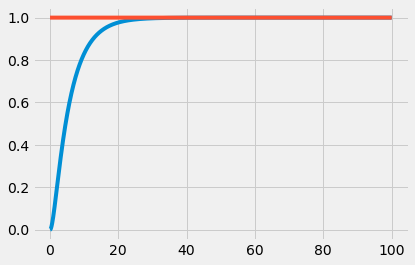

In [11]:
plt.plot(t, xd[1,:])
plt.plot(t, u[2,:])

In [12]:
def run_stochastic(u, v, Fi, La, Ga):
    '''Runs simulation of stochastic system.'''
    _, n = u.shape
    x = np.zeros(u.shape)
    
    for k in range(n-1):
        x[:,k+1,np.newaxis] = Fi@x[:,k,np.newaxis] + La@u[:,k,np.newaxis] + Ga@v[:,k,np.newaxis]
    
    return x

In [13]:
Fi, La, Ga = c2d_stochastic(F, L, G, Q, dt)
v = np.vstack((np.zeros(n),
               np.zeros(n),
               np.random.randn(n)))
xs = run_stochastic(u, v, Fi, La, Ga)

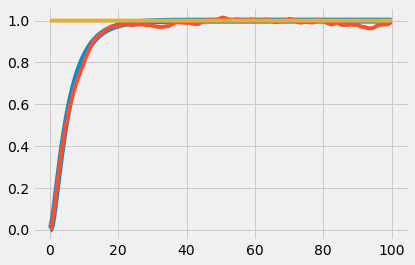

In [14]:
plt.plot(t, xd[1,:], lw=6)
plt.plot(t, xs[1,:], lw=4)
plt.plot(t, u[2,:])

# 4 Optimal Kalman Filter

In [15]:
def run_kalman(z, u, Fi, La, Ga, P0, R, mi, suboptimal=False):
    '''Runs Kalman filter simulation'''
        
    # System order and simulation length
    p, nm = z.shape
    _, n = u.shape
    I = np.eye(p)
    
    # State vector estimates
    x_bar = np.zeros((p,n))  # a-priori
    x_hat = np.zeros((p,nm))  # a-posteriori

    # Covariance matrice estimates
    P_bar = np.zeros((n,p,p))  # a-priori
    P_hat = np.zeros((nm,p,p))  # a-posteriori
    P_bar[0,...] = P_hat[0,...] = P0
    
    # Run simulation
    for k in range(n-1):
        if k%mi == 0:
            km = k//mi
            
            # Compute Kalman gain
            Kk = P_bar[k,...]@H.T@inv(H@P_bar[k,...]@H.T + R)

            # Measurement update
            x_hat[:,km,np.newaxis] = x_bar[:,k,np.newaxis] + Kk@(z[:,km,np.newaxis] - H@x_bar[:,k,np.newaxis])
            P_hat[km,...] = (I - Kk@H)@P_bar[k,...]
            
            if suboptimal:
                P_hat[km,...] = P_hat[km,...]@(I - Kk@H).T + Kk@R@Kk.T

            xk = x_hat[:,km,np.newaxis]
            Pk = P_hat[km,...]

        # Time update
        x_bar[:,k+1,np.newaxis] = Fi@xk + La@u[:,k,np.newaxis]
        P_bar[k+1,...] = Fi@Pk@Fi.T + Ga@Ga.T
    
    # Extract diagonals
    s_bar = np.array([P_bar[:,i,i] for i in range(p)])
    s_hat = np.array([P_hat[:,i,i] for i in range(p)])
    
    return (x_bar, x_hat, s_bar, s_hat)


In [16]:
# Measurement update interval
mi = 100

# Kalman filter matrices
Fi, La, Ga = c2d_stochastic(F, L, G, Q, dt*mi)

# Measurements
z = H@xs[:,:-1:mi]
nm = z.shape[1]
z += np.vstack((np.random.randn(nm),  # Measurements
                     np.zeros(nm),
                     np.zeros(nm)))

# Run simulation
(x_bar, x_hat, s_bar, s_hat) = run_kalman(z, u, Fi, La, Ga, P0, R, mi)

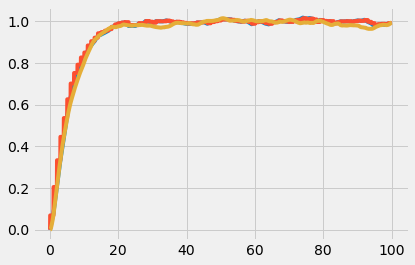

In [17]:
tm = np.arange(t0,tf,mi*dt)
plt.plot(tm, x_hat[1,:])
plt.plot(t, x_bar[1,:])
plt.plot(t, xs[1,:])

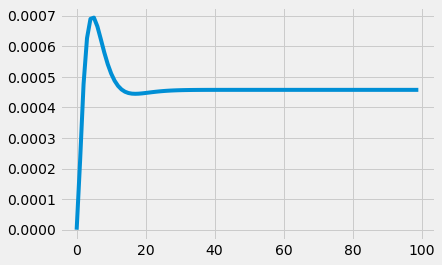

In [18]:
plt.plot(tm, sqrt(s_bar[1,:-1:mi]) - sqrt(s_hat[1,:]))

# 5 Monte Carlo simulation of optimal system

In [19]:
# Measurement update interval
mi = 100

# Kalman filter model matrices
FiK, LaK, GaK = c2d_stochastic(F, L, G, Q, dt*mi)

# System model matrices (stochastic, equals filter model)
FiS, LaS, GaS = c2d_stochastic(F, L, G, Q, dt)

# Run simulations
N = 10
X_bar, X_hat = list(), list()
for i in tqdm(range(N)):
    # New stochasitic process simulation
    v = np.vstack((np.zeros(n),
                   np.zeros(n),
                   np.random.randn(n)))
    x = run_stochastic(u, v, FiS, LaS, GaS)
    x = H@x[:,:-1:mi]
    nm = x.shape[1]
    
    # Take measurements
    z = H@x + np.vstack((np.random.randn(nm),
                       np.zeros(nm),
                       np.zeros(nm)))
    
    # Run Kalman filter simulation
    (x_bar, x_hat, s_bar, s_hat) = run_kalman(z, u, Fi, La, Ga, P0, R, mi)
    X_bar.append(x_bar)
    X_hat.append(x_hat)

100%|██████████| 10/10 [00:01<00:00,  5.32it/s]


In [20]:
X_hat = np.concatenate(X_hat).reshape(N,3,-1)
X_bar = np.concatenate(X_bar).reshape(N,3,-1)

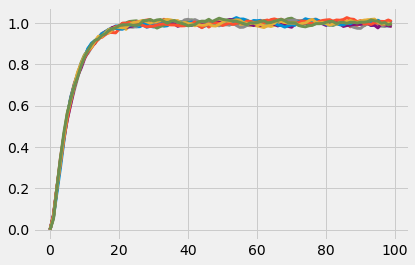

In [21]:
plt.plot(tm, X_hat[:,1,:].T, lw=3)
plt.show()

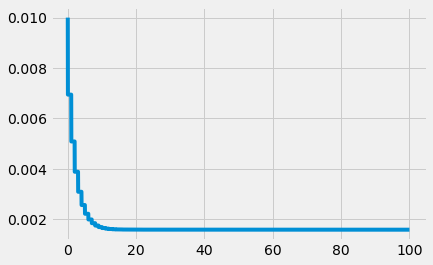

In [22]:
plt.plot(t, s_bar[1,:])
plt.show()

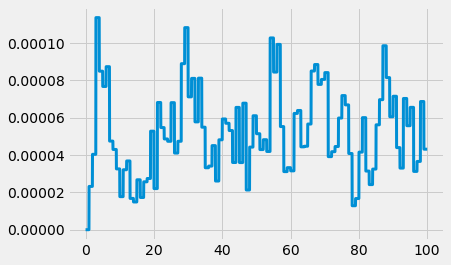

In [23]:
plt.plot(t, X_bar[:,1,:].var(axis=0), lw=3)
plt.show()

# 6 Error budget for optimal Kalman filter

In [62]:
# Total
(_, _, _, s_tot) = run_kalman(z, u, Fi, La, Ga, P0, R, mi, suboptimal=True)
err_tot = np.linalg.norm(s_tot, axis=0)

# Bias error
# Position
M = np.diag([1,0,0])
(_, _, _, s_pos) = run_kalman(z, u, Fi, La, Ga, M@P0, R, mi, suboptimal=True)
err_pos = np.linalg.norm(s_pos, axis=0)

# Velocity
M = np.diag([0,1,0])
(_, _, _, s_vel) = run_kalman(z, u, Fi, La, Ga, M@P0, R, mi, suboptimal=True)
err_vel = np.linalg.norm(s_vel, axis=0)

# Armature current
M = np.diag([0,0,1])
(_, _, _, s_cur) = run_kalman(z, u, Fi, La, Ga, M@P0, R, mi, suboptimal=True)
err_cur = np.linalg.norm(s_cur, axis=0)



In [63]:
err_tot_control = sqrt(1/3*(err_pos**2 + err_vel**2 + err_cur**2))

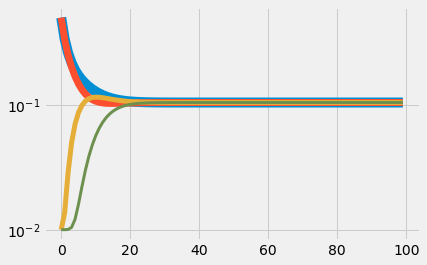

In [70]:
plt.plot(tm, err_tot, lw=10)
plt.plot(tm, err_pos, lw=7)
plt.plot(tm, err_vel, lw=5)
plt.plot(tm, err_cur, lw=3)
plt.yscale('log')

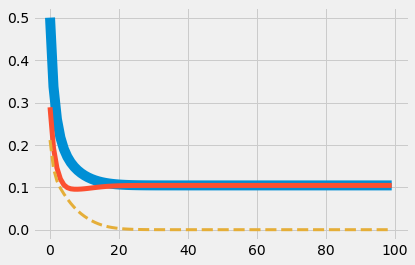

In [78]:
plt.plot(err_tot, lw=10)
plt.plot(err_tot_control, lw=5)
plt.plot(err_tot - err_tot_control, lw=3, ls='--')
